In [1]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import os
from pathlib import Path

def mask_radiation_data(input_shp="Radiation_2015_2016.shp", 
                       output_shp="Masked_Radiation_Data.shp", 
                       mask_radius=1000, 
                       random_seed=None):
    """
    Mask radiation monitoring locations from 'Radiation_2015_2016.shp' with secure displacement.
    
    Parameters:
    - input_shp: Path to input shapefile (default: "Radiation_2015_2016.shp")
    - output_shp: Output path (default: "Masked_Radiation_Data.shp")
    - mask_radius: Displacement radius in meters (default 1000m)
    - random_seed: Set for reproducible results (default random)
    """
    try:
        # ==================================================================
        # 1. INPUT VALIDATION
        # ==================================================================
        print(f"Processing radiation data from: {input_shp}")
        
        if not os.path.exists(input_shp):
            raise FileNotFoundError(f"Error: Could not find '{input_shp}'. "
                                  f"Please ensure:\n"
                                  f"1. The file exists in: {os.getcwd()}\n"
                                  f"2. You've included the .shp extension\n"
                                  f"3. All related shapefile files (.dbf, .shx, etc.) are present")

        # ==================================================================
        # 2. DATA LOADING
        # ==================================================================
        print("Loading radiation data...")
        gdf = gpd.read_file(input_shp)
        
        # Check geometry types
        if not all(isinstance(geom, Point) for geom in gdf.geometry):
            bad_types = set(geom.geom_type for geom in gdf.geometry)
            raise ValueError(f"Error: Only Point geometries supported in '{input_shp}'. Found: {bad_types}")

        # ==================================================================
        # 3. COORDINATE SYSTEM HANDLING
        # ==================================================================
        original_crs = gdf.crs
        if not gdf.crs.is_projected:
            print("Converting to UTM CRS for accurate meter-based displacement...")
            centroid = gdf.geometry.unary_union.centroid
            utm_zone = 32600 + int((centroid.x + 180)/6) + 1  # Northern hemisphere
            gdf = gdf.to_crs(f"EPSG:{utm_zone}")
            print(f"Converted to UTM Zone EPSG:{utm_zone} for displacement")

        # ==================================================================
        # 4. SPATIAL MASKING
        # ==================================================================
        if random_seed is not None:
            np.random.seed(random_seed)
            print(f"Using reproducible random seed: {random_seed}")

        def displace_point(point, radius):
            """Displace point within circular radius"""
            angle = np.random.uniform(0, 2 * np.pi)
            distance = np.random.uniform(0, radius)
            return Point(
                point.x + distance * np.cos(angle),
                point.y + distance * np.sin(angle)
            )

        print(f"Displacing points with {mask_radius}m radius...")
        gdf['geometry'] = gdf.geometry.apply(displace_point, radius=mask_radius)

        # Convert back to original CRS if needed
        if original_crs != gdf.crs:
            gdf = gdf.to_crs(original_crs)

        # ==================================================================
        # 5. OUTPUT GENERATION
        # ==================================================================
        output_dir = Path(output_shp).parent
        output_dir.mkdir(parents=True, exist_ok=True)
        
        gdf.to_file(output_shp)
        print("\n==============================================")
        print(f"✔ Successfully created masked data: {output_shp}")
        print(f"✔ Displaced {len(gdf)} radiation monitoring points")
        print(f"✔ Mask radius: {mask_radius} meters")
        print("==============================================")
        
        return gdf

    except Exception as e:
        print("\n==============================================")
        print(f"✖ Error processing '{input_shp}':")
        print(str(e))
        print("==============================================")
        return None

# ==================================================================
# MAIN EXECUTION - EDIT THESE PARAMETERS AS NEEDED
# ==================================================================
if __name__ == "__main__":
    # 1. SPECIFY YOUR SHAPEFILE NAME HERE (if different from default)
    input_shapefile = "Radiation_2015_2016.shp"  # ← Your shapefile name here
    
    # 2. Configure these parameters:
    params = {
        "output_shp": "Masked_Radiation_Output.shp",  # Output filename
        "mask_radius": 2000,  # Displacement radius in meters (1000-5000 recommended)
        "random_seed": 42  # Set to None for different results each run
    }
    
    # Run the masking process
    result = mask_radiation_data(input_shp=input_shapefile, **params)
    
    if result is None:
        print("\nTroubleshooting Tips:")
        print(f"1. Verify '{input_shapefile}' exists in: {os.getcwd()}")
        print("2. Ensure all shapefile components (.shp, .dbf, .shx) are present")
        print("3. Check the file contains Point geometries")
        print("4. Try running in a new Python environment if packages are missing")

Processing radiation data from: Radiation_2015_2016.shp
Loading radiation data...
Using reproducible random seed: 42
Displacing points with 2000m radius...

✔ Successfully created masked data: Masked_Radiation_Output.shp
✔ Displaced 206 radiation monitoring points
✔ Mask radius: 2000 meters


In [2]:
import geopandas as gpd
data = gpd.read_file("Masked_Radiation_Output.shp")
print(data.head())

   OBJECTID Site_Num Site_Name      X_GIS       Y_GIS  Lat_Field_  Long_Field  \
0         1        1      None  43.023571 -102.482155   43.031889 -102.482250   
1         2        2      None  43.429153 -102.418236   43.422750 -102.419556   
2         3        3      None  43.404949 -102.341896   43.384861 -102.336361   
3         4        4      None  43.222237 -102.480614   43.222278 -102.480611   
4         5        5      None  43.273239 -102.961044   43.281389 -102.950167   

   mR_hr_1  mR_hr_2  mR_hr_3  mRem_hr_Av Field_Note Label_Name  Ln_mRemHr_  \
0    0.021    0.025    0.026    0.024000       None       None   -3.729701   
1    0.019    0.017    0.016    0.017333       None       None   -4.055124   
2    0.020    0.024    0.020    0.021333       None       None   -3.847484   
3    0.022    0.024    0.018    0.021333       None       None   -3.847484   
4    0.019    0.023    0.028    0.023333       None       None   -3.757872   

   uRemHr_Avg                        geometr

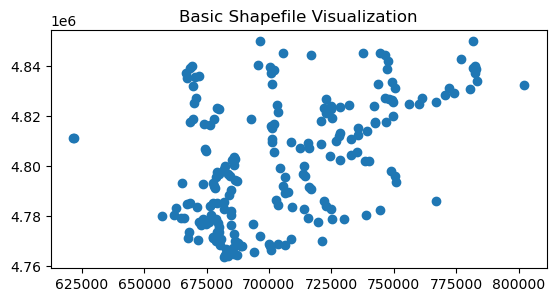

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
shapefile_path = "Masked_Radiation_Output.shp"  # Replace with your file path
gdf = gpd.read_file(shapefile_path)

# Plot with default settings
gdf.plot()
plt.title("Basic Shapefile Visualization")
plt.show()

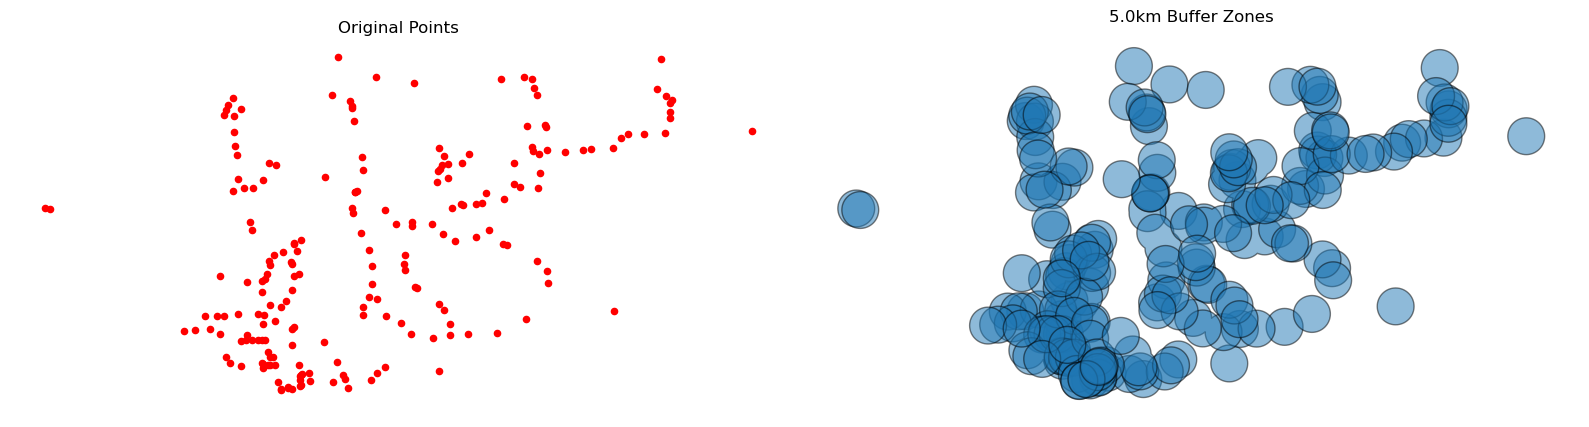

Saved buffer zones to Shawns_Masked_Locations.shp


In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# 1. Load the radiation data
gdf = gpd.read_file("Radiation_2015_2016.shp")

# 2. Convert to UTM for accurate buffering in meters
original_crs = gdf.crs
if not gdf.crs.is_projected:
    centroid = gdf.geometry.unary_union.centroid
    utm_zone = 32600 + int((centroid.x + 180)/6) + 1  # Northern hemisphere UTM
    gdf = gdf.to_crs(f"EPSG:{utm_zone}")

# 3. Create buffer zones (adjust size as needed)
buffer_distance = 5000  # 5km buffer radius in meters
buffered = gdf.copy()
buffered['geometry'] = gdf.geometry.buffer(buffer_distance)

# 4. Merge overlapping buffers
dissolved = buffered.dissolve(by='mRem_hr_Av')  # Or use aggfunc='sum'/'mean'

# 5. Convert back to original CRS
dissolved = dissolved.to_crs(original_crs)

# 6. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original points
gdf.to_crs(original_crs).plot(ax=ax1, color='red', markersize=20)
ax1.set_title("Original Points")
ax1.set_axis_off()

# Buffered zones
dissolved.plot(ax=ax2, alpha=0.5, edgecolor='black')
ax2.set_title(f"{buffer_distance/1000}km Buffer Zones")
ax2.set_axis_off()

plt.tight_layout()
plt.show()

# 7. Save results
dissolved.to_file("Shawns_Masked_Locations.shp")
print(f"Saved buffer zones to Shawns_Masked_Locations.shp")

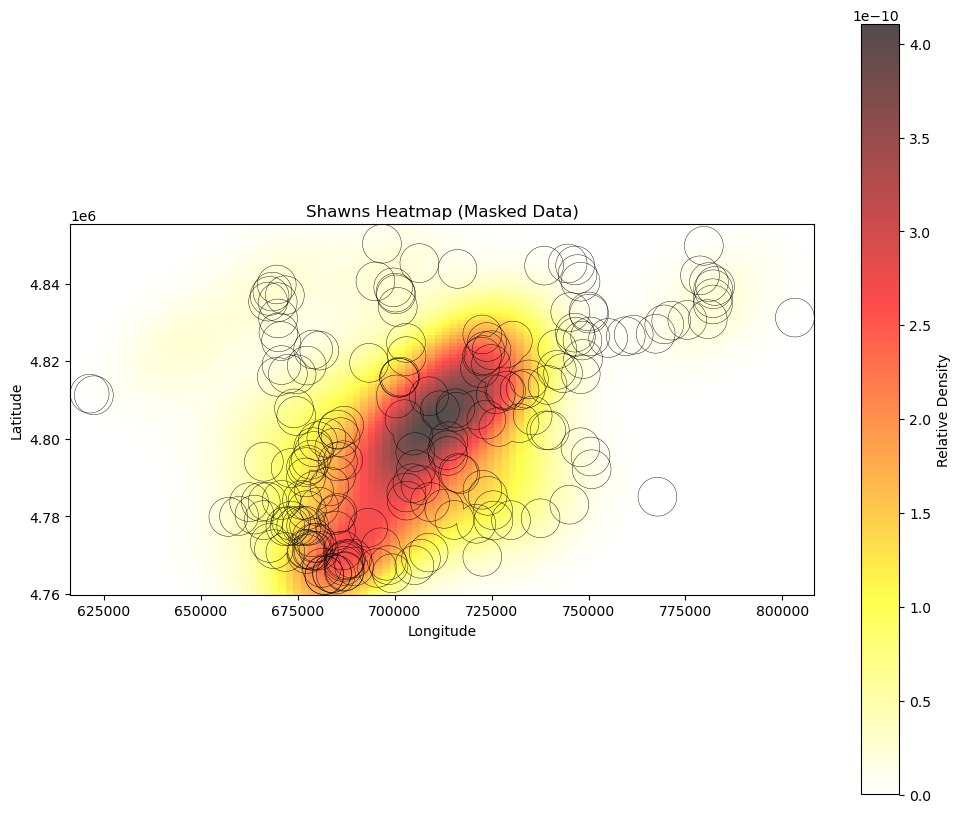

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Load your buffered data (polygons)
buffers = gpd.read_file("Shawns_Masked_locations.shp")  # Replace with your file

# 1. Convert polygons to representative points (centroids)
points = buffers.geometry.centroid

# 2. Extract coordinates for KDE
coords = np.column_stack([points.x, points.y])

# 3. Create grid for heatmap
xmin, ymin, xmax, ymax = buffers.total_bounds
grid_size = 100  # Resolution
xi, yi = np.meshgrid(
    np.linspace(xmin, xmax, grid_size),
    np.linspace(ymin, ymax, grid_size)
)

# 4. Calculate Kernel Density Estimate (KDE)
kde = gaussian_kde(coords.T)
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# 5. Plot
plt.figure(figsize=(12, 10))
plt.imshow(
    zi, 
    extent=[xmin, xmax, ymin, ymax],
    origin='lower', 
    cmap='hot_r',  # 'viridis', 'plasma', etc.
    alpha=0.7
)

# Overlay buffer outlines (optional)
buffers.boundary.plot(
    ax=plt.gca(),
    color='black',
    linewidth=0.3
)

plt.colorbar(label='Relative Density')
plt.title("Shawns Heatmap (Masked Data)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from pathlib import Path

# ==================================================================
# 1. Load Data with Error Checking
# ==================================================================
def load_shapefile(dir_path, filename):
    """Load shapefile with validation"""
    base_path = Path(dir_path) / filename
    required_exts = ['.shp', '.shx', '.dbf']
    missing = [str(base_path.with_suffix(ext)) for ext in required_exts 
               if not base_path.with_suffix(ext).exists()]
    
    if missing:
        raise FileNotFoundError(f"Missing files:\n" + "\n".join(missing))
    return gpd.read_file(base_path.with_suffix('.shp'))

try:
    # Load uranium buffers (your masked data)
    buffers = load_shapefile(".", "Shawns_Masked_locations.shp")
    
    # Load tribal boundary (from correct directory)
    boundary = load_shapefile("wazi_ahanhan_oyanke_boundary", "wazi_ahanhan_oyanke.shp")
    
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Please verify:")
    print("1. Files exist in the specified paths")
    print("2. All .shp/.shx/.dbf components are present")
    exit()

# ==================================================================
# 2. Prepare Data
# ==================================================================
# Ensure matching coordinate systems
buffers = buffers.to_crs(boundary.crs)

# Calculate heatmap from buffer centroids
points = buffers.geometry.centroid
coords = np.column_stack([points.x, points.y])

# Create grid based on boundary extent
xmin, ymin, xmax, ymax = boundary.total_bounds
xi, yi = np.meshgrid(np.linspace(xmin, xmax, 100), 
                     np.linspace(ymin, ymax, 100))

# Calculate density
kde = gaussian_kde(coords.T)
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))

# ==================================================================
# 3. Plot with Boundary
# ==================================================================
plt.figure(figsize=(12, 10))

# First plot the boundary (zorder=1 puts it underneath)
boundary.plot(
    ax=plt.gca(),
    color='none',            # Transparent fill
    edgecolor='darkgreen',   # Boundary color
    linewidth=2,            # Thicker border
    zorder=1
)

# Add heatmap (zorder=2 goes above boundary)
plt.imshow(
    zi.reshape(xi.shape),
    extent=[xmin, xmax, ymin, ymax],
    origin='lower',
    cmap='hot_r',           # Yellow-Red color scheme
    alpha=0.7,              # Transparency
    zorder=2
)

# Optional: Add buffer outlines (zorder=3 top layer)
buffers.boundary.plot(
    ax=plt.gca(),
    color='black',
    linewidth=0.5,
    alpha=0.3,
    zorder=3
)

# Style the plot
plt.colorbar(label='Uranium Concentration Density')
plt.title("Uranium Concentrations in Wazi Ahanhan Oyanke Territory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Save and show
plt.savefig("uranium_heatmap_with_boundary.png", dpi=300, bbox_inches='tight')
plt.show()

ERROR: Missing files:
wazi_ahanhan_oyanke_boundary/wazi_ahanhan_oyanke.shp
wazi_ahanhan_oyanke_boundary/wazi_ahanhan_oyanke.shx
wazi_ahanhan_oyanke_boundary/wazi_ahanhan_oyanke.dbf
Please verify:
1. Files exist in the specified paths
2. All .shp/.shx/.dbf components are present


NameError: name 'boundary' is not defined

: 

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')  # Temporarily suppress warnings

# 1. Load data in chunks (prevents memory crashes)
try:
    boundary = gpd.read_file("wazi_ahanhan_oyanke_boundary/wazi_ahanhan_oyanke.shp")
    buffers = gpd.read_file("Shawns_Masked_locations.shp", rows=5000)  # Limit rows if needed
except Exception as e:
    print(f"Load failed: {str(e)}")
    exit()

# 2. Simplify geometries (reduces memory usage)
boundary.geometry = boundary.geometry.simplify(0.001)
buffers.geometry = buffers.geometry.simplify(0.001)

# 3. Create low-resolution heatmap (safer for large datasets)
points = buffers.geometry.centroid
coords = np.column_stack([points.x, points.y])

# Use boundary extent with smaller grid
xmin, ymin, xmax, ymax = boundary.total_bounds
grid_size = 50  # Reduced from 100 for stability
xi, yi = np.meshgrid(np.linspace(xmin, xmax, grid_size), 
                     np.linspace(ymin, ymax, grid_size))

# 4. Calculate KDE in batches
try:
    kde = gaussian_kde(coords.T)
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
except MemoryError:
    print("Memory error: Try smaller grid_size or sample your data")
    exit()

# 5. Plot with memory-efficient settings
fig, ax = plt.subplots(figsize=(10, 8))  # Smaller figure size
boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
plt.imshow(zi.reshape(xi.shape), extent=[xmin,xmax,ymin,ymax], 
           cmap='Reds', alpha=0.6, zorder=1)
plt.colorbar(label='Density')
plt.title("Stable Heatmap Visualization")
plt.show()

Load failed: wazi_ahanhan_oyanke_boundary/wazi_ahanhan_oyanke.shp: No such file or directory


NameError: name 'boundary' is not defined

: 